# Chapitre 3 : Caractérisation du réseau de nanosatellites

In [1]:
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *   # Import principal : module de simulation

%matplotlib inline 

In [2]:
NB_NODES = 50       # Nombre de satellites (noeuds)
DURATION = 10000    # Nombre total d'échantillons disponibles
REVOLUTION = 1800   # Nombre d'échantillons pour 1 révolution en orbite lunaire
SAMPLE_FREQ = 0.1   # Fréquence d'échantillonnage (Hz) : toutes les 10 secondes
CONNECTION_RANGE = 30000    # Portée de connexion (m)

# Variables globales pour la génération des figures
TMAX = REVOLUTION/SAMPLE_FREQ # temps maximal échantillonné
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # index converti en secondes

## 1. Formattage des données pour l'analyse
### 1.1 Importation du dataset
Coordonnées (x,y,z) de chaque nanosatellite à chaque pas de temps

In [3]:
PATH = '..\..\data\cnes_swarm50\\track_'
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)

satellites[0]

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.428846e+05,-4.516533e+05,-4.604007e+05,-4.691266e+05,-4.778306e+05,-4.865122e+05,-4.951711e+05,-5.038068e+05,-5.124189e+05,-5.210071e+05,...,1.440812e+06,1.444147e+06,1.447475e+06,1.450795e+06,1.454108e+06,1.457413e+06,1.460711e+06,1.464001e+06,1.467284e+06,1.470559e+06
y,-7.388676e+05,-7.522884e+05,-7.656739e+05,-7.790237e+05,-7.923370e+05,-8.056132e+05,-8.188518e+05,-8.320520e+05,-8.452134e+05,-8.583352e+05,...,2.329204e+06,2.334225e+06,2.339233e+06,2.344229e+06,2.349213e+06,2.354185e+06,2.359145e+06,2.364092e+06,2.369028e+06,2.373951e+06
z,-2.011435e+06,-2.004528e+06,-1.997528e+06,-1.990435e+06,-1.983248e+06,-1.975968e+06,-1.968596e+06,-1.961132e+06,-1.953577e+06,-1.945930e+06,...,3.661057e+06,3.655167e+06,3.649258e+06,3.643331e+06,3.637384e+06,3.631419e+06,3.625435e+06,3.619433e+06,3.613412e+06,3.607372e+06


### 1.2 Conversion en objet Swarm (module swarm_sim)
L'objet Swarm est caractérisé, à chaque instant *t*, par la portée de connexion et les positions des noeuds.

In [4]:
swarm_data = {}

with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

Converting to Swarm: 100%|██████████| 1800/1800 [00:06<00:00, 298.91it/s]


In [5]:
# Création de copies de swarm_data pour la comparaison des graphes pondérés et non pondérés (non présenté dans le manuscrit)
swarm_plain = copy.deepcopy(swarm_data) # graphes non pondérés, portée de connexion fixe
swarm_weighted = copy.deepcopy(swarm_data) # graphes pondérés, portée de connexion variable

### 1.3 Création de la topologie : établissement des ISL d'après la portée de connexion

In [6]:
# Génération des matrices d'adjacence
neighbor_matrix_list_plain = [swarm_plain[t].neighbor_matrix() for t in range(REVOLUTION)]
neighbor_matrix_list_weighted = [swarm_weighted[t].neighbor_matrix(weighted=True) for t in range(REVOLUTION)]

In [7]:
# Création des graphes associés  
with tqdm(total=REVOLUTION, desc='Création des graphes') as pbar:
    for t in range(REVOLUTION):
        swarm_plain[t].create_graph()
        swarm_weighted[t].create_graph()
        pbar.update(1)

Création des graphes: 100%|██████████| 1800/1800 [00:18<00:00, 97.32it/s] 


In [114]:
# Enlever les ISL trop chers de l'essaim (ceux dont le coût est supérieur au coût du plus court chemin)
with tqdm(total = REVOLUTION, desc = 'Nettoyage des ISL redondants') as pbar:
    for t in range(REVOLUTION):
        swarm_weighted[t].remove_expensive_edges()
        pbar.update(1)

Nettoyage des ISL redondants: 100%|██████████| 1800/1800 [06:28<00:00,  4.63it/s]


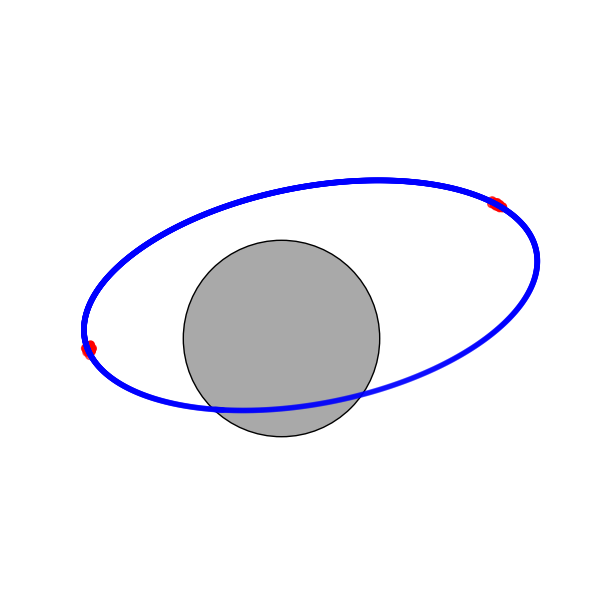

In [9]:
def plot_trajectory(nid, swarm_data, n_color='blue'):
    """
    This function plots the trajectory of a specific node (nid) in a given swarm topology.

    Parameters:
    nid (int): The node ID for which the trajectory needs to be plotted.
    swarm_data (dict): A dictionary containing the swarm data, where the keys are timestamps and the values are Swarm objects.
    n_color (str, optional): The color of the trajectory points. Default is 'blue'.

    Returns:
    None. The function creates a 3D scatter plot to visualize the trajectory of the specified node.
    """
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [sw.nodes[nid].x for sw in swarm_data.values()]
    y_data = [sw.nodes[nid].y for sw in swarm_data.values()]
    z_data = [sw.nodes[nid].z for sw in swarm_data.values()]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=10)
    ax.scatter(0,0,0, c='darkgray', edgecolor='black', s=20000)
    for t in (200,1100):
        ax.scatter([node.x for node in swarm_data[t].nodes], 
                   [node.y for node in swarm_data[t].nodes], 
                   [node.z for node in swarm_data[t].nodes], 
                   c='red', 
                   s=30)
    
    
plot_trajectory(0, swarm_data)

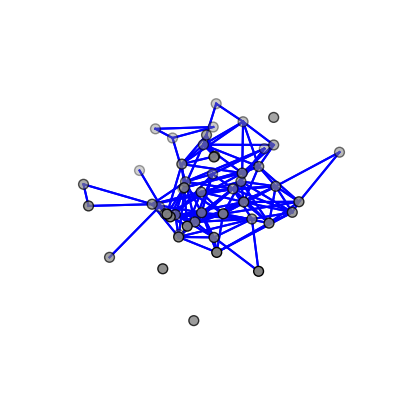

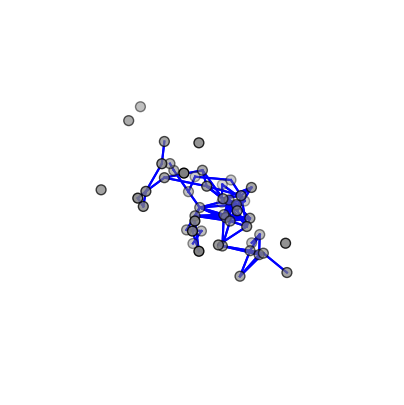

In [111]:
# Topologies à portée de connexion fixe             
swarm_plain[200].plot_edges()
swarm_plain[1100].plot_edges()

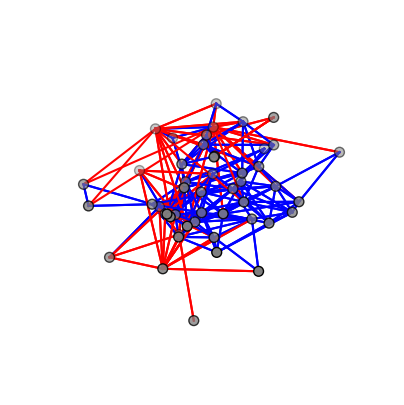

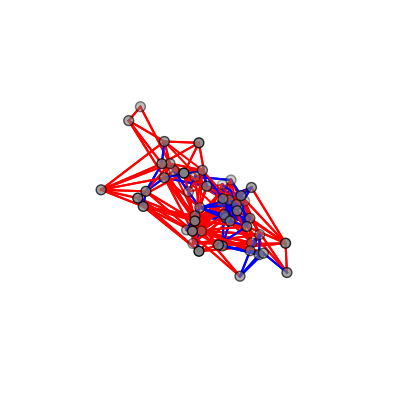

In [115]:
# Topologies à portée de connexion variable (30 km ou 60 km, version présente dans le manuscrit)             
swarm_weighted[200].plot_edges()
swarm_weighted[1100].plot_edges()

## 2. Propriétés du réseau

### 2.1 Mobilité
Vitesse de déplacement de l'essaim

In [9]:
def compute_velocity(sw1, sw2):
    """
    This function computes the swarm velocity from two consecutive swarm topologies.

    Parameters:
    sw1 (Swarm): The first swarm object at time t.
    sw2 (Swarm): The second swarm object at time t+1.

    Returns:
    list: A list containing the node velocities of the swarm. The velocities are computed as the average distance between the nodes of the two swarm topologies at each time step.
    """
    return [n1.compute_dist(n2)*SAMPLE_FREQ for (n1,n2) in zip(sw1.nodes, sw2.nodes)]


swarm_velocity = [np.mean(compute_velocity(swarm_data[t], swarm_data[t+1])) for t in range(REVOLUTION-1)]
avg_swarm_velocity = np.mean(swarm_velocity)
print('Vitesse de déplacement moyenne de l\'essaim :', np.round(avg_swarm_velocity,2), 'm/s soit', np.round(avg_swarm_velocity*3.6,2), 'km/h')

Vitesse de déplacement moyenne de l'essaim : 1160.26 m/s soit 4176.95 km/h


In [10]:
# Distance par rapport à la Lune (pour comparaison)

def compute_moon_dist(sw: Swarm):
    """
    This function computes the distance of each node in the swarm to the Moon.

    Parameters:
    sw (Swarm): The swarm object at time t.
   
    Returns:
    list: A list containing the distance of each node in the swarm to the Moon.
    """
    moon = Node(-1, x=0, y=0, z=0)  # Le système de coordonnées est centré sur la Lune
    return [moon.compute_dist(n) for n in sw.nodes]  


moon_dist = [np.mean(compute_moon_dist(swarm_data[t])) for t in range(REVOLUTION)]
moon_dist_km = [e/1000 for e in moon_dist]

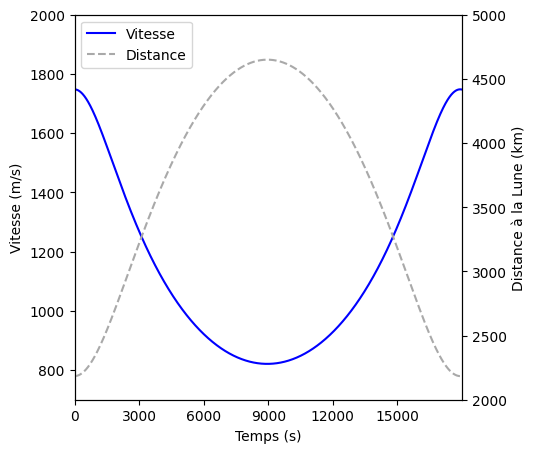

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX[:-1], swarm_velocity, c='blue', label='Vitesse')
ax.set_xlim(0, TMAX)
ax.set_ylim(700,2000)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Vitesse (m/s)')
ax.set_xticks(np.arange(0, TMAX, 3000))

ax2 = ax.twinx()
l3 = ax2.plot(IDX, moon_dist_km, c='darkgray', ls='--', label='Distance')
ax2.set_ylim(2000,5000)
ax2.set_ylabel('Distance à la Lune (km)')

lns = l1 + l3
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

Analyse de la mobilité relative des nanosatellites

In [12]:
def compute_distance_matrix(swarm_chunk):
    """
    This function computes the distance matrix of each pair of nodes in a given chunk of time.

    Parameters:
    swarm_chunk (dict): A dictionary containing the swarm data, where the keys are timestamps and the values are Swarm objects.

    Returns:
    distance_matrix (dict): A dictionary containing the distance matrices for each timestamp in the chunk. 
    The distance matrix is a square matrix where the element at position (i,j) represents the distance between nodes i and j at the given timestamp.
    """
    distance_matrix = {}
    with tqdm(total=REVOLUTION, desc='Computing Distance matrix') as pbar:
        for t in range(REVOLUTION):
            distance_matrix[t] = swarm_chunk[t].distance_matrix()
            pbar.update(1)
    return distance_matrix


dm = compute_distance_matrix(swarm_data)
avg_distances_time = [np.mean(dm_time) for dm_time in dm.values()]

Computing Distance matrix: 100%|██████████| 1800/1800 [00:01<00:00, 1161.03it/s]


In [32]:
def compute_relative_velocity(dm1, dm2):
    """
    This function computes the relative velocity of each pair of nodes in two consecutive swarm topologies.

    Parameters:
    dm1 (dict): A dictionary containing the distance matrix of each pair of nodes at time t.
    dm2 (dict): A dictionary containing the distance matrix of each pair of nodes at time t+1.

    Returns:
    list: A list containing the relative velocities of each pair of nodes in the two consecutive swarm topologies.
    """
    return [[abs(e1-e2) for (e1,e2) in zip(dm1[i],dm2[i])] for i in range(len(dm1))]


relative_velocity = [np.mean(compute_relative_velocity(dm[t], dm[t+1])) for t in range(REVOLUTION-1)]
avg_relative_velocity = np.mean(relative_velocity)
print('Vitesse relative moyenne des satellites :', np.round(avg_relative_velocity,2), 'm/s soit', np.round(avg_relative_velocity*3.6,2), 'km/h')

Vitesse relative moyenne des satellites : 102.35 m/s soit 368.46 km/h


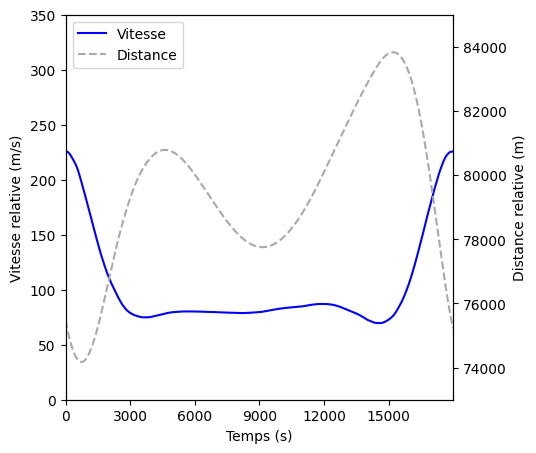

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX[:-1], relative_velocity, c='blue', label='Vitesse')
ax.set_ylim(0,350)
ax.set_ylabel('Vitesse relative (m/s)')
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_xlabel('Temps (s)')

ax2 = ax.twinx()
l2 = ax2.plot(IDX, avg_distances_time, c='darkgray', ls='--', label='Distance')
ax2.set_ylabel('Distance relative (m)')
ax2.set_ylim(73000,85000)

lns = l1 + l2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

In [18]:
# Distance relative moyenne des noeuds sur une période de révolution (m)
np.mean(avg_distances_time)

79426.88622259893

### 2.2 Densité des noeuds
Degré moyen et distribution (non présenté dans le manuscrit)

In [112]:
# Degrés à portée fixe
degrees_plain = [swarm_plain[t].degree() for t in range(REVOLUTION)]
avg_degree_plain = [np.mean(deg) for deg in degrees_plain]

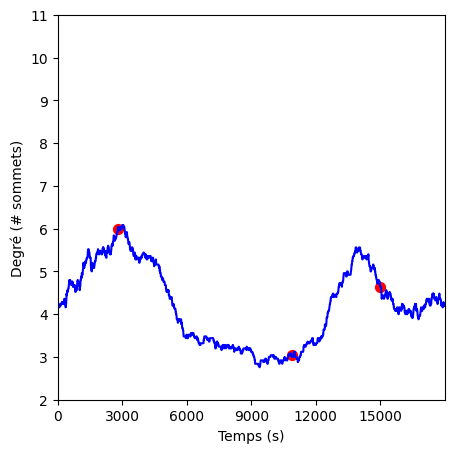

In [113]:
# Evolution temporelle du degré moyen
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_degree_plain, c='blue', label='Degré')
ax.scatter([t1/SAMPLE_FREQ, t2/SAMPLE_FREQ, t3/SAMPLE_FREQ], 
            [avg_degree_plain[t1],
             avg_degree_plain[t2],
             avg_degree_plain[t3]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(2,11)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Degré (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))

Text(0, 0.5, 'Distribution')

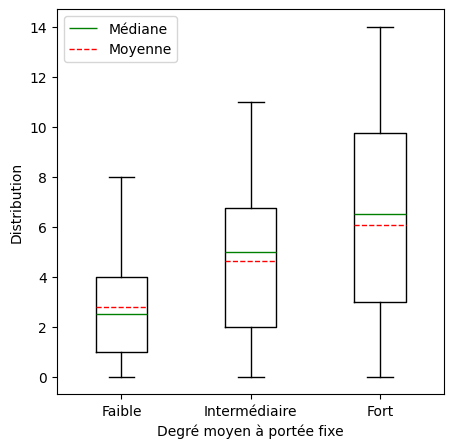

In [50]:
# Distribution des degrés
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([degrees_plain[t2],
                 degrees_plain[t3],
                 degrees_plain[t1]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_xticklabels(['Faible','Intermédiaire','Fort'])
ax.set_xlabel('Degré moyen à portée fixe')
ax.set_ylabel('Distribution')

In [116]:
# Degrés à portée variable (30 km ou 60 km)
degrees_weighted = [swarm_weighted[t].degree() for t in range(REVOLUTION)]
avg_degree_weighted = [np.mean(deg) for deg in degrees_weighted]

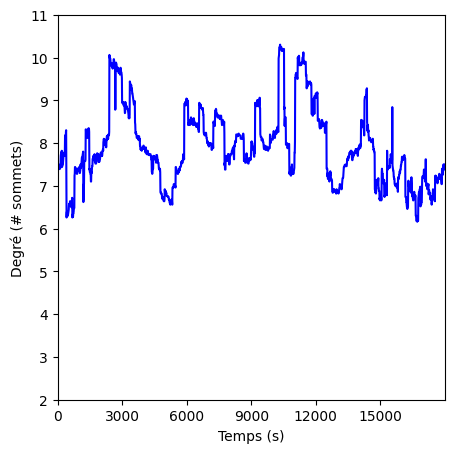

In [117]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_degree_weighted, c='blue', label='Degré')
ax.set_xlim(0, TMAX)
ax.set_ylim(2,11)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Degré (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))

Force des sommets, moyenne et distribution (présenté dans le manuscrit)

In [44]:
# Pour graphes pondérés : calcul de la force (strength) des sommets
strengths = [swarm_weighted[t].strength() for t in range(REVOLUTION)]
avg_strengths = [np.mean(st) for st in strengths]
avg_strength_revolution = np.mean(avg_strengths)
print('Force moyenne sur une révolution :', np.round(avg_strength_revolution,2), 'noeuds')

Force moyenne sur une révolution : 5.14 noeuds


In [88]:
T_HIGH, T_LOW, T_MED = 280, 1090, 1500

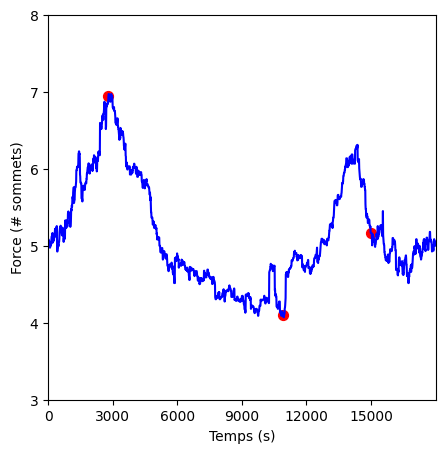

In [89]:
# Evolution temporelle de la force moyenne
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_strengths, c='blue', label='Degré')
#ax.hlines(y=avg_strength_revolution, xmin=0, xmax=IDX[-1])
ax.scatter([T_HIGH/SAMPLE_FREQ, T_LOW/SAMPLE_FREQ, T_MED/SAMPLE_FREQ], 
            [avg_strengths[T_HIGH],
             avg_strengths[T_LOW],
             avg_strengths[T_MED]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(3,8)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Force (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))

(0.0, 16.0)

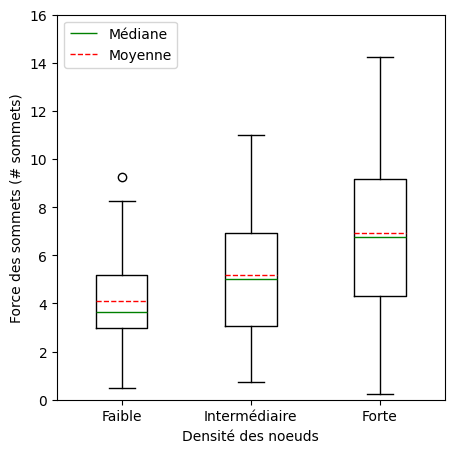

In [67]:
# Distribution des forces
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([strengths[T_LOW],
                 strengths[T_MED],
                 strengths[T_HIGH]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_xticklabels(['Faible','Intermédiaire','Forte'])
ax.set_xlabel('Densité des noeuds')
ax.set_ylabel('Force des sommets (# sommets)')
ax.set_ylim(0,16)

Coefficient de clustering

In [71]:
# Coefficients de clustering à portée adaptative (30 km ou 60 km)
coefs_weighted = [swarm_weighted[t].cluster_coef(weight='proba') for t in range(REVOLUTION)]
avg_coef_weighted = [np.mean(list(c.values())) for c in coefs_weighted]
avg_coef_revolution = np.mean(avg_coef_weighted)

print('Coefficient de clustering moyen sur une révolution :', np.round(avg_coef_revolution,2))

Coefficient de clustering moyen sur une révolution : 0.35


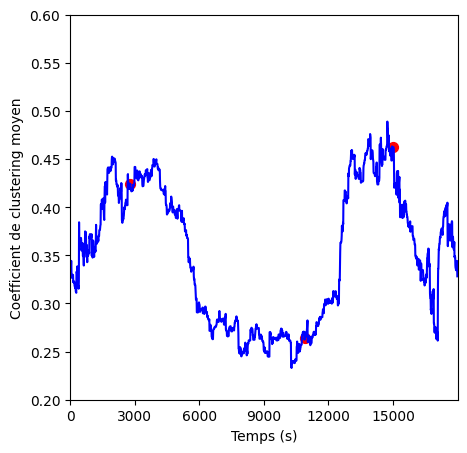

In [92]:
# Evolution temporelle du coefficient de clustering moyen
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, avg_coef_weighted, c='blue', label='Clustering')
ax.scatter([T_HIGH/SAMPLE_FREQ, T_LOW/SAMPLE_FREQ, T_MED/SAMPLE_FREQ], 
            [avg_coef_weighted[T_HIGH],
             avg_coef_weighted[T_LOW],
             avg_coef_weighted[T_MED]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(0.2,0.6)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Coefficient de clustering moyen')
ax.set_xticks(np.arange(0, TMAX, 3000))

(-0.05, 1.1)

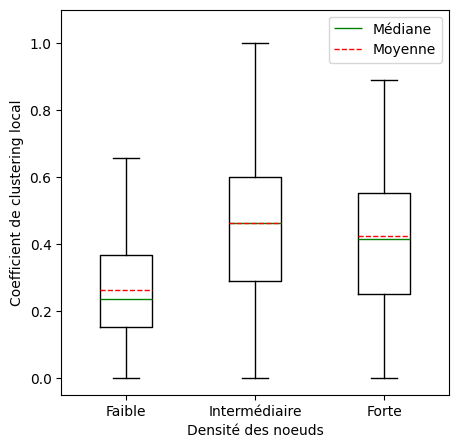

In [96]:
# Distribution des coefficients de clustering
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([list(coefs_weighted[T_LOW].values()),
                 list(coefs_weighted[T_MED].values()),
                 list(coefs_weighted[T_HIGH].values())], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper right')
ax.set_xticklabels(['Faible','Intermédiaire','Forte'])
ax.set_xlabel('Densité des noeuds')
ax.set_ylabel('Coefficient de clustering local')
ax.set_ylim(-0.05,1.1)

### 2.3 Disponibilité des ISL

Distribution des temps d'inter-contact (ICT)

In [97]:
def pairwise_ict(nmat: dict):
    """
    This function computes the pairwise Inter-Contact Times (ICT) for each pair of nodes in the swarm.

    Parameters:
    nmat (dict): A dictionary containing the neighbor matrices at each timestamp. 
    The neighbor matrix is a square matrix where the element at position (i,j) represents the adjacency of nodes i and j (0 or 1).

    Returns:
    list: A list containing the pairwise ICTs at each timestamp. 
    """
    total_contact = {}
    for n1 in range(NB_NODES):
        total_contact[n1] = [np.mean([min(nmat[t][n1][n2],1) for t in range(REVOLUTION)]) for n2 in range(NB_NODES)]
    ict = [[(1-n2)*100 for n2 in tc] for tc in total_contact.values()]
    return ict

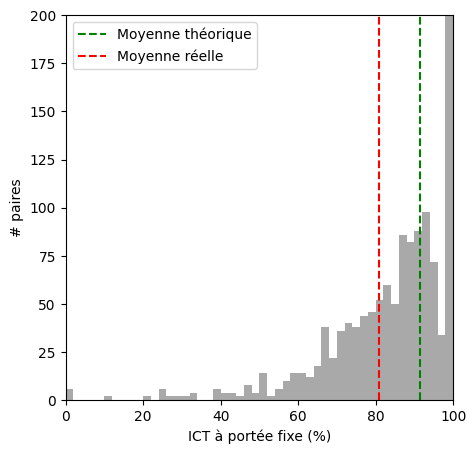

In [72]:
ict_plain = pairwise_ict(neighbor_matrix_list_plain)
existing_ict_plain = [[e for e in row if e<100] for row in ict_plain]

avg_ict_all = np.mean(ict_plain)
avg_ict_exist = np.mean([np.mean(row) for row in existing_ict_plain])


plt.figure(figsize=(5,5))
plt.hist([ e for row in ict_plain for e in row], bins=50, color='darkgray')
plt.vlines(x=avg_ict_all, ymin=0, ymax=200, color='green', ls='--', label='Moyenne théorique')
plt.vlines(x=avg_ict_exist, ymin=0, ymax=200, color='red', ls='--', label='Moyenne réelle')

plt.xlabel('ICT à portée fixe (%)')
plt.ylabel('# paires')
plt.xlim(0,100)
plt.ylim(0,200)
plt.legend()

(-4.0, 104.0)

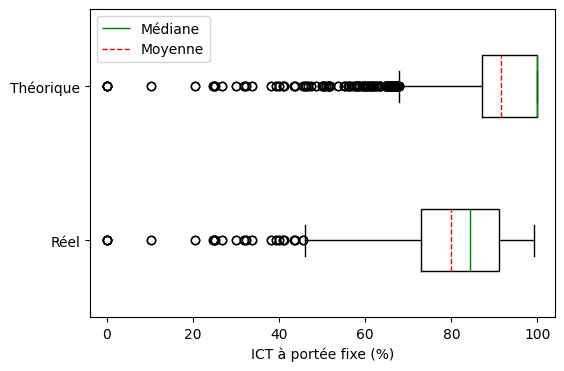

In [73]:
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot([[e for row in existing_ict_plain for e in row],
                 [e for row in ict_plain for e in row]], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_yticklabels(['Réel','Théorique'])
#ax.set_xlabel('Essaim')
ax.set_xlabel('ICT à portée fixe (%)')
ax.set_xlim(-4,104)

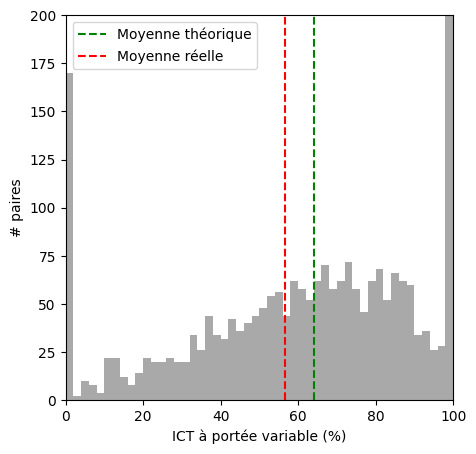

In [98]:
ict_weighted = pairwise_ict(neighbor_matrix_list_weighted)
existing_ict_weighted = [[e for e in row if e<100] for row in ict_weighted]

avg_ict_all = np.mean(ict_weighted)
avg_ict_exist = np.mean([np.mean(row) for row in existing_ict_weighted])


plt.figure(figsize=(5,5))
plt.hist([ e for row in ict_weighted for e in row], bins=50, color='darkgray')
plt.vlines(x=avg_ict_all, ymin=0, ymax=200, color='green', ls='--', label='Moyenne théorique')
plt.vlines(x=avg_ict_exist, ymin=0, ymax=200, color='red', ls='--', label='Moyenne réelle')

plt.xlabel('ICT à portée variable (%)')
plt.ylabel('# paires')
plt.xlim(0,100)
plt.ylim(0,200)
plt.legend()

(-4.0, 104.0)

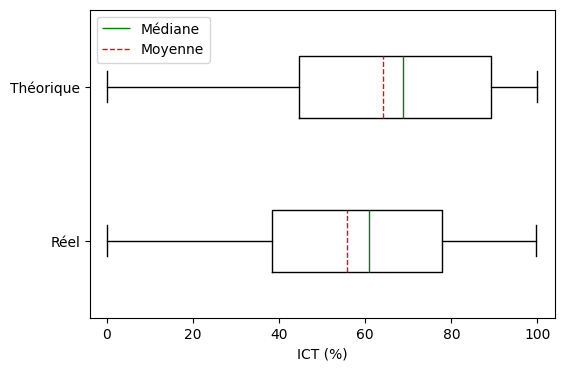

In [100]:
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot([[e for row in existing_ict_weighted for e in row],
                 [e for row in ict_weighted for e in row]], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_yticklabels(['Réel','Théorique'])
#ax.set_xlabel('Essaim')
ax.set_xlabel('ICT (%)')
ax.set_xlim(-4,104)

In [103]:
print('ICT moyen théorique :', np.round(np.mean(ict_weighted),2),'%')
print('ICT moyen réel :', np.round(np.mean([e for row in existing_ict_weighted for e in row]),2),'%')

ICT moyen théorique : 64.05 %
ICT moyen réel : 55.81 %


Temps d'isolement

In [118]:
def isolation_time(degrees):
    iso = {}
    for nid in range(NB_NODES):
        degs = [degrees[t][nid] for t in range(REVOLUTION)]
        iso[nid] = len([e for e in degs if e==0])/REVOLUTION*100
    return iso

iso_plain = isolation_time(degrees_plain)
iso_weighted = isolation_time(degrees_weighted)

(-4.0, 104.0)

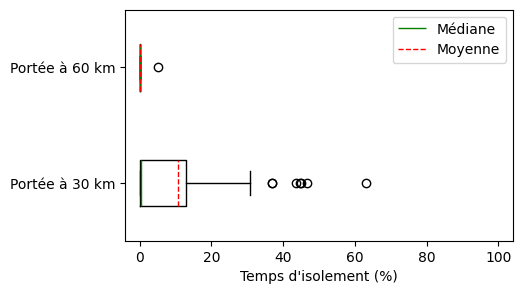

In [120]:
fig,ax = plt.subplots(figsize=(5,3))

bp = ax.boxplot([list(iso_plain.values()),
                 list(iso_weighted.values())], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper right')
ax.set_yticklabels(['Portée à 30 km','Portée à 60 km'])
ax.set_xlabel('Temps d\'isolement (%)')
ax.set_xlim(-4,104)

Composantes connexes

In [121]:
nb_cc_plain = [nx.number_connected_components(swarm_plain[t].graph) for t in range(REVOLUTION)]
nb_cc_weighted = [nx.number_connected_components(swarm_weighted[t].graph) for t in range(REVOLUTION)]

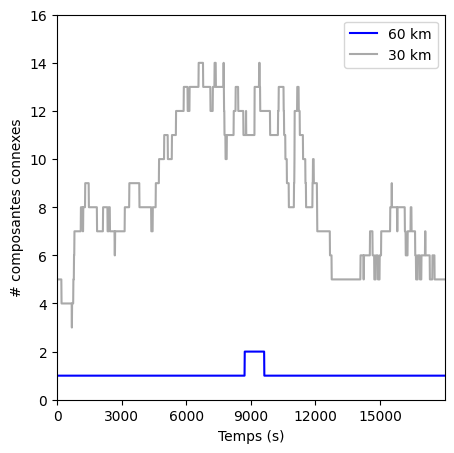

In [124]:
plt.figure(figsize=(5,5))
plt.plot(IDX, nb_cc_weighted, c='blue', label='60 km')
plt.plot(IDX, nb_cc_plain, c='darkgray', label='30 km')
plt.xlabel('Temps (s)')
plt.ylabel('# composantes connexes')
plt.xlim(0,TMAX)
plt.ylim(0,16)
plt.xticks(np.arange(0, TMAX, 3000))
plt.legend()